In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.experiments import *

import matplotlib.pyplot as plt
from matplotlib import colors


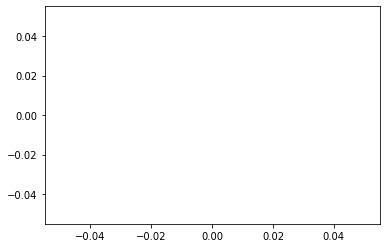

In [2]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11",
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1
})

e_order = ['CHIME',
          'HETDEX',
          'COMAP',
           'CCAT-prime',
           'SPHEREx',
]

In [183]:
plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2

ell_idxs = [37, 62, 73, 99]
titles = [100, 500, 1000, 5000]


In [84]:
_alphas = {
    'CHIME': 150,
    'HETDEX': 400,
    'COMAP': 250,
    'SPHEREx': 250,
    'CCAT-prime': 500,
}

In [85]:
tilde_chi = np.arange(0, 2, 0.001)

def plot_gap(alpha, 
             beta,
             text,
             ax,
            gap_size = 180):
    
    if(alpha >= 1000):
        gap_size = 200
    tilde_chi_prime = beta + tilde_chi

    if np.all(tilde_chi_prime > 1):
        return
    idxs = np.where(tilde_chi_prime <= 1)

    mid_idx = len(tilde_chi[idxs]) // 2
    mid_x = tilde_chi[idxs][mid_idx]
    mid_y = tilde_chi_prime[idxs][mid_idx]
    if((mid_x <= 0.1 or mid_x >= 0.9)):
        return


    ax.plot(tilde_chi[idxs][:mid_idx-gap_size//2], 
            tilde_chi_prime[idxs][:mid_idx-gap_size//2], 
            ls='-',
            c='k', lw=0.25)

    ax.plot(tilde_chi[idxs][mid_idx+gap_size//2:], 
            tilde_chi_prime[idxs][mid_idx+gap_size//2:], 
            ls='-',
            c='k', lw=0.25)


    ax.text(mid_x, mid_y, text, 
            ha='center', va='center', rotation=45, fontsize= 3.8)



In [86]:
n_bins = 100


In [87]:
Lambda_text = {
    24: r'$\Lambda^{-1} = 10$ {\sf Mpc}',
    18: r'$\Lambda^{-1} = 100$ {\sf Mpc}'
}

In [88]:
import matplotlib.lines as mlines


In [145]:
import matplotlib.patches as mpatches


In [153]:
e_colors = {
    'CHIME': '#8932B8',
    'HETDEX': '#3C44AA',
    'COMAP': '#5E7C16',
    'SPHEREx': '#F9801D',
    'CCAT-prime':'#B02E26'
}

/tmp/ipykernel_169655/383715214.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad = 0.0)


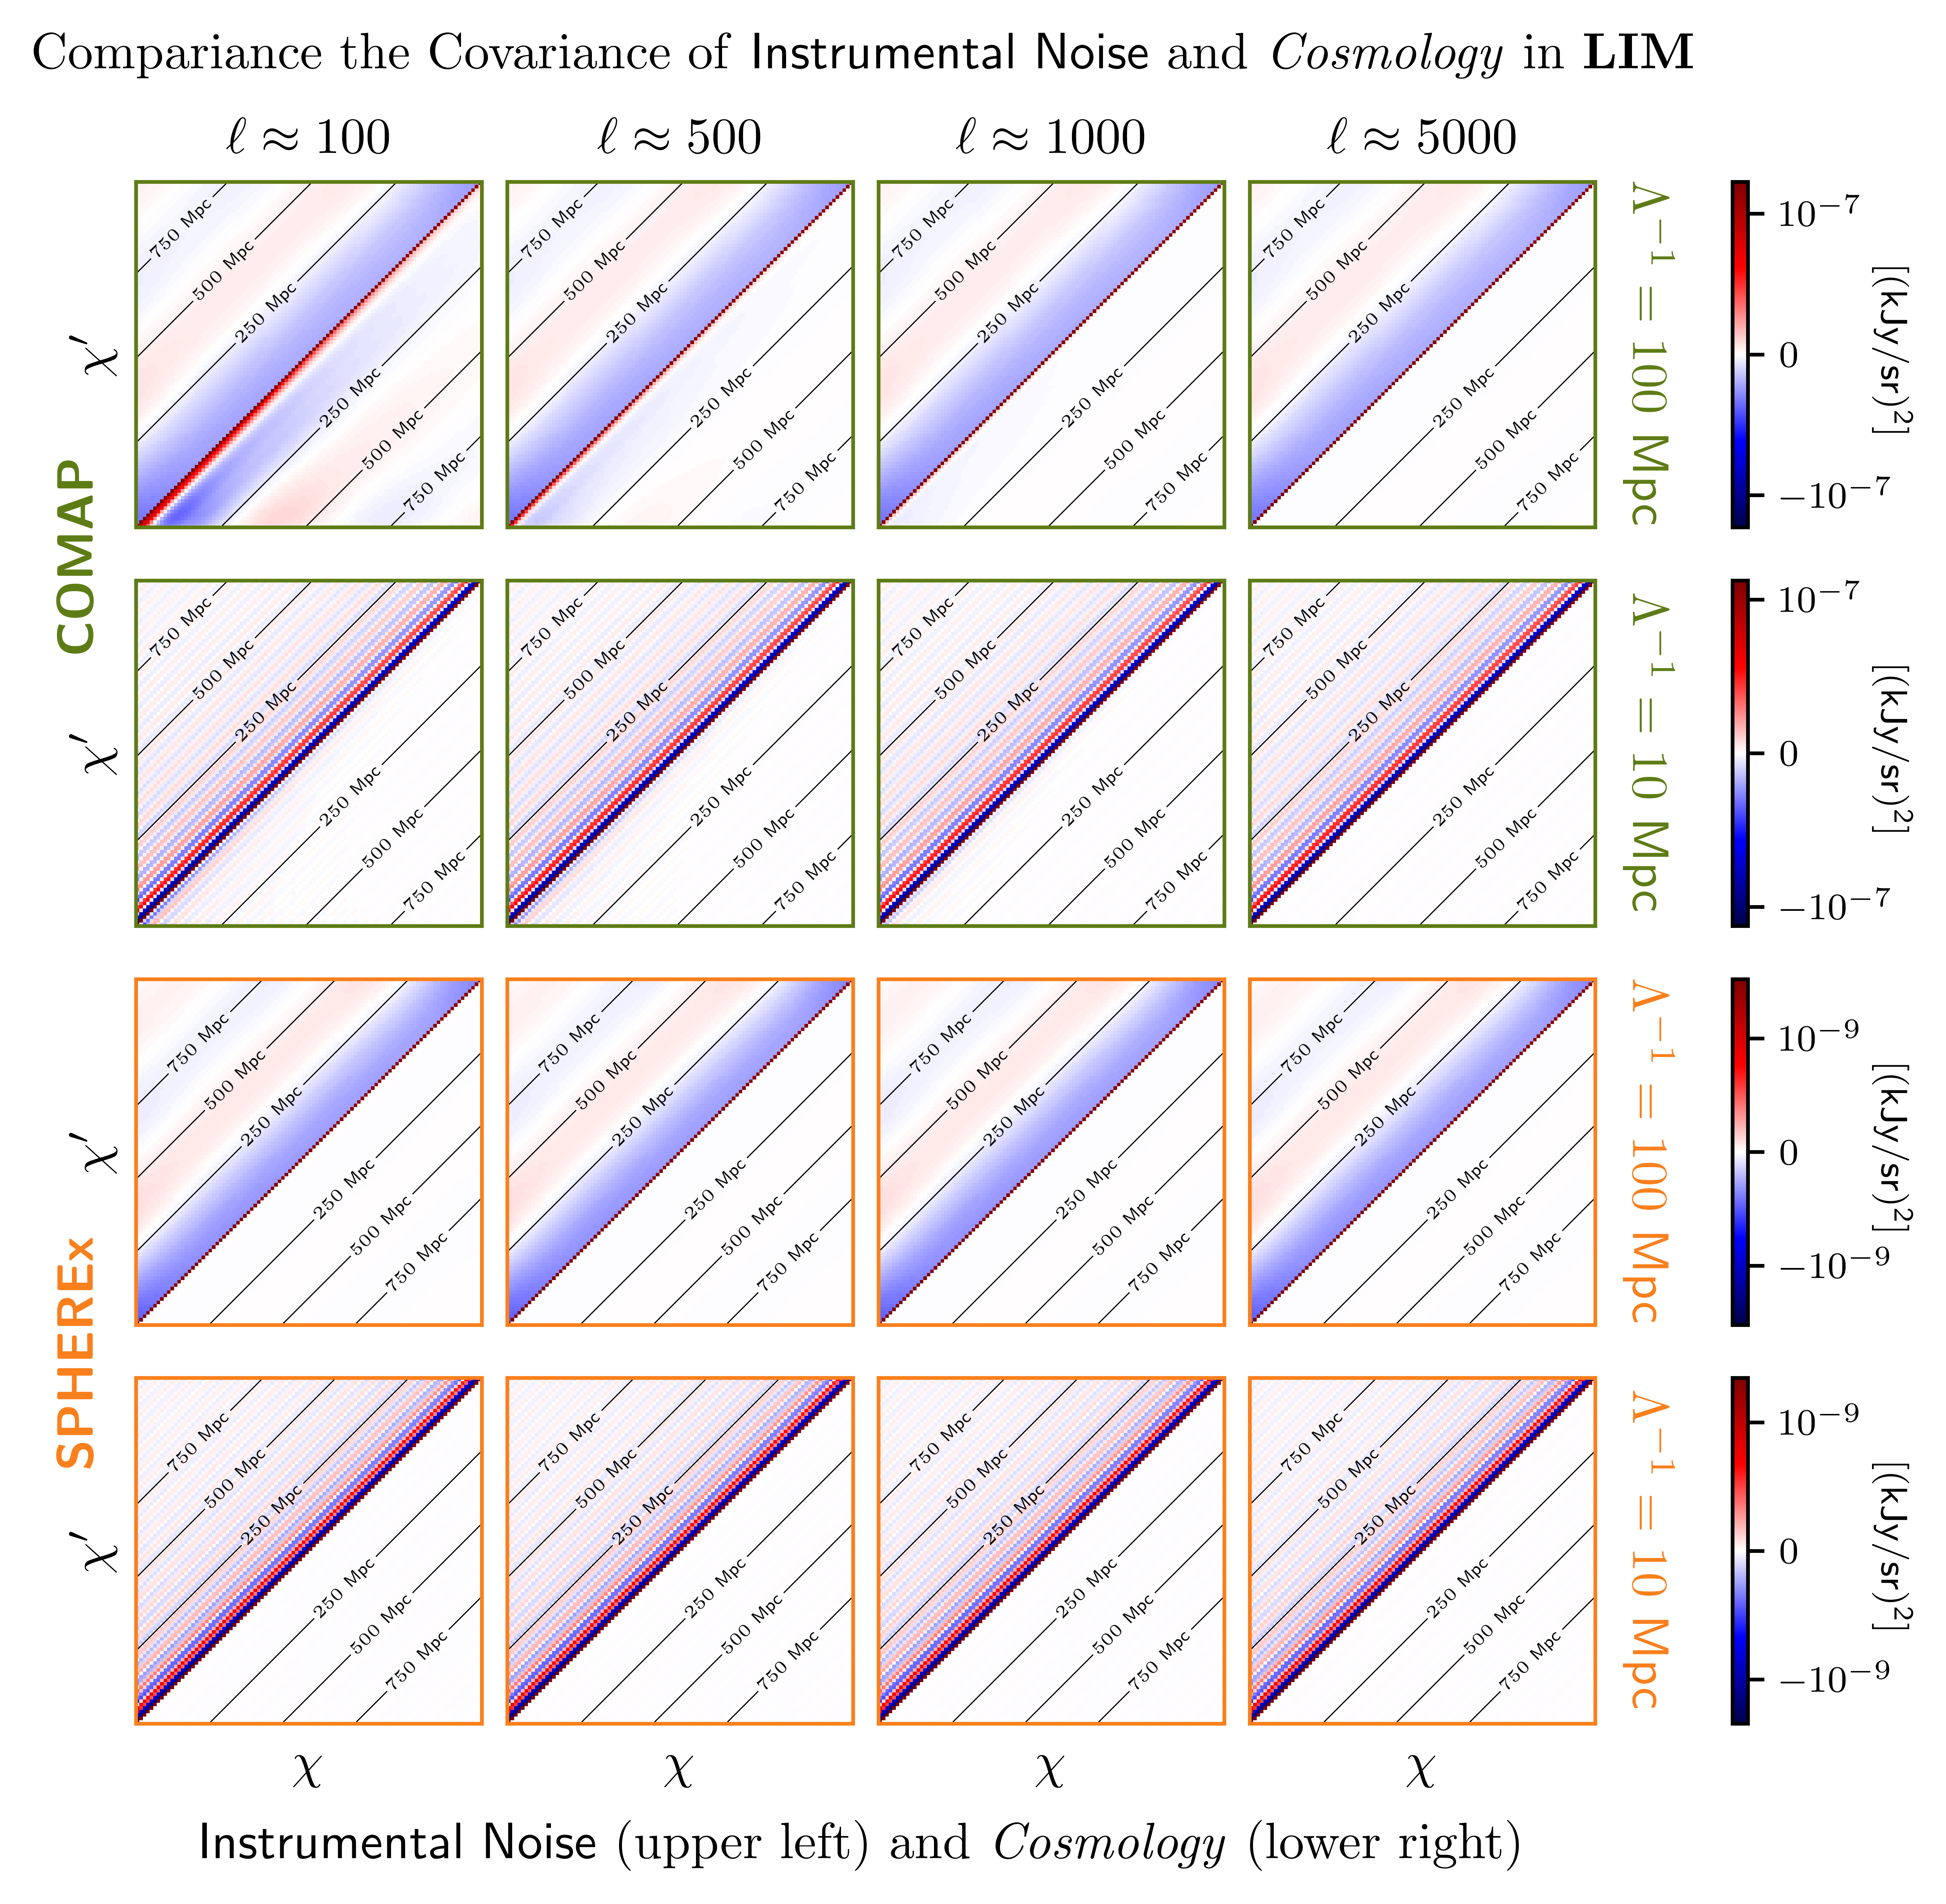

In [190]:
fig, _axs = plt.subplots(nrows=4, ncols=4, 
                             figsize = (5.8/5*4, 3.65/3*4), facecolor = 'none', 
                         dpi = 1000,sharex=True,sharey=True)



plt.tight_layout(pad = 0.0)



for e_idx, e in enumerate(['COMAP', 'SPHEREx']):
    axs = _axs[2*e_idx:2*e_idx+2]
    zmin = experiments[e]['zmin']
    zmax = experiments[e]['zmax']
    line_str = experiments[e]['line_str']
    
    Omega_field  =  np.array(experiments[e]['Omega_field'].to(u.rad**2)) #rad^2
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    
    chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
    chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
    dchi_binned = np.mean(np.diff(chi_bin_edges))

    extent = [0,1,0,1]
    _, Pei = experiments[e]['f_Pei']()
    Pei = np.max(Pei).to(u.Mpc**3  * (u.kJy/u.sr)**2)
    Pei = Pei.value # kJy2 Mpc3 / sr2

    def get_eHIeHI(Lambda_idx):
        eComb_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_comb_'
        eComb_fname +='zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, 
                                                                                   zmax, 
                                                                                   Lambda_idx, 
                                                                                   n_bins)
        eComb = np.load(eComb_fname)
        return Pei * eComb

    for Lidx, Lambda_idx in enumerate([18, 24]):
        eHIeHI = get_eHIeHI(Lambda_idx)
        _eHIeHI = eHIeHI * np.tri(*eHIeHI.shape)
        _eHIeHI[np.where(_eHIeHI == 0)] = None

        IHiIHi_oup_fname = '/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/LIM_auto/'
        IHiIHi_oup_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_b_%d_jax_qmc.npy'%(line_str,
                                                                                       zmin, zmax, 
                                                                                       Lambda_idx, 
                                                                                       n_bins)

        IHiIHi = np.load(IHiIHi_oup_fname)

        for ell_idx in range(len(ells)):
            #Cheng and Higham, 1998
            eigenvalues, eigenvectors = np.linalg.eig(IHiIHi[ell_idx])
            patched_eigenvalues = np.where(eigenvalues <0, 0.0, eigenvalues)
            IHiIHi[ell_idx] = eigenvectors @ np.diag(patched_eigenvalues) @ eigenvectors.T
            
            
        vb1 = np.max(np.abs(eHIeHI))
        vb2 = np.max(np.abs(IHiIHi))
        
        assert(vb1 >= vb2)
            
        vb = max(vb1, vb2)
            
        lin_factor = 1
        log10vb = np.log10(vb)
        linthresh = 10**(np.floor(log10vb))
        linthresh = 10**((log10vb)-1)
        vminmax = 10**(log10vb)

        norm = colors.SymLogNorm(linthresh=linthresh, 
                                 linscale=lin_factor,
                                 vmin=-vminmax, 
                                 vmax=vminmax, 
                                 base=10)


            
        for l_idx, ell_idx in enumerate(ell_idxs):
            ax = axs[Lidx, l_idx]
    

            ax.imshow(IHiIHi[ell_idx],
                  cmap='seismic',
                 extent=extent,
                      norm = norm,
#                       vmin=-vb,
#                       vmax=vb,
                 interpolation = 'none',
                 origin = 'lower')


    
    

            im = ax.imshow(_eHIeHI,
                           cmap = 'seismic',
                           extent=extent,
                           norm = norm,
#                            vmin=-vb,
#                            vmax=vb,
                           interpolation = 'none',
                           origin = 'lower')        
    
    
    
    
            ax.tick_params(axis='both', which='both', length=0)
            ax.set_xticks([])
            ax.set_yticks([])

            if(Lambda_idx == 24 and e_idx == 1):
                ax.set_xlabel(r'$\chi$')#, c=e_colors[e])

            if(l_idx == 0):
                ax.set_ylabel(r"$\chi'$")#, c=e_colors[e])
                
            if(e_idx ==0 and Lambda_idx == 18):
                ax.set_title(r'$\ell \approx %d$'%(titles[l_idx]), fontsize=11)
            
            if(l_idx == len(ell_idxs)-1):
                ax.text(1.08, 0.5, Lambda_text[Lambda_idx], 
                     transform=ax.transAxes, 
                     ha='left', va='center',
                        c=e_colors[e],
                    rotation=-90)


            #plot distance measures
            for i in range(5):
                alpha = (i+1)*_alphas[e] #Mpc
                plot_gap(alpha=alpha,beta=alpha/(chimax-chimin), 
                         text = r'%d \textsf{Mpc}'%(np.abs(alpha)), ax=ax)
                plot_gap(alpha=-alpha,beta=-alpha/(chimax-chimin), 
                         text = r'%d \textsf{Mpc}'%(np.abs(alpha)), ax=ax)

            ax.set_xlim(0,1)
            ax.set_ylim(0,1)
            for spine in ax.spines.values():
                spine.set_edgecolor(e_colors[e])


        _bbox = ax.get_position()
        cbar_ax = fig.add_axes([1.08, 
                                _bbox.ymin, 
                                0.01, 
                                _bbox.ymax-_bbox.ymin])  # [left, bottom, width, height]



        cbar = fig.colorbar(im, cax=cbar_ax,
                           orientation='vertical',)
        cbar.ax.set_ylabel(r'$[{\sf (kJy/sr)^2}]$', rotation=-90, fontsize = 8)#, color=e_colors[e])
        cbar.ax.tick_params(labelsize=8, direction='out')#, color=e_colors[e], labelcolor=e_colors[e])
        cbar.set_ticks(ticks = [-(10**(np.floor(log10vb))), 0, 10**(np.floor(log10vb))])
        cbar.ax.minorticks_off()
        
#         for spine in cbar.ax.spines.values():
#             spine.set_edgecolor(e_colors[e])


#cbar

# Get figure dimensions
fig_width, fig_height = fig.get_size_inches()


bbox_1 = _axs[1,0].get_position()
bbox_2 = _axs[2,0].get_position()
bbox_3 = _axs[1,-1].get_position()
bbox_00 = _axs[0,0].get_position()
bbox_01 = _axs[0,1].get_position()
bbox_02 = _axs[0,2].get_position()


yline = (bbox_1.ymin + bbox_2.ymax)/2


fig.text(x = bbox_00.xmin-0.05, y=(bbox_00.ymin+bbox_1.ymax)/2, s=r'\textsf{\textbf{COMAP}}',
        verticalalignment = 'center', horizontalalignment = 'left', fontsize=11, rotation = 90,
        c=e_colors['COMAP'])

fig.text(x = bbox_00.xmin-0.05, y=yline - ((bbox_00.ymin+bbox_1.ymax)/2 - yline), s=r'\textsf{\textbf{SPHEREx}}',
        verticalalignment = 'center', horizontalalignment = 'left', fontsize=11, rotation = 90,
        c=e_colors['SPHEREx'])



fig.text((bbox_02.xmin+bbox_01.xmax)/2, 1.05, r"Compariance the Covariance of \textsf{Instrumental Noise} and \textit{Cosmology} in \textbf{LIM}",
         ha='center', 
         va='bottom', 
        fontsize=11)

fig.text((bbox_02.xmin+bbox_01.xmax)/2, -0.05, r"\textsf{Instrumental Noise} (upper left) and \textit{Cosmology} (lower right)",
         ha='center', 
         va='bottom', 
        fontsize=11)


plt.savefig('figures/013.007.pdf', bbox_inches='tight')